# Interpolação de um dado sísmico - Método MPFI

*   PET - Física UFRN
*   Petiano : Matheus Felipe Freitas Tomaz
*   Data : 26 de Junho de 2023

O objetivo `Notebook` é apresentar uma aplicação direta do MP (*Matching Pursuit*), método discutido em um notebook anterior, no conxtexto da Geofísica (Sismologia).

Esse Notebook está divido nas sequintes seções :

*   **Entendo um sismograma**
*   **A importância da interpolação** 
*   **Configurando o dado**
*   **Interpolando**
*   **Conclusão**

## Pré - requisitos


É importante que que o leitor já tenha lido o `notebook` [Algoritmo de reconstrução esparsa - MPFI](https://github.com/MathPhelip/PET.py/blob/main/Algoritmo%20de%20reconstru%C3%A7%C3%A3o%20esparsa%20-%20MPFI.ipynb), onde entendemos e desenvolvemos o método do MPFI que será usado aqui.

## Importando bibliotecas necessárias

In [1]:
import numpy as np
import random as rd
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft2, fft2, fftshift
from sklearn.metrics import mean_squared_error, r2_score

## 1 - Entendendo um sismograma

****

A coleta de petróleo e outras substância em solo ou em mar aberto é de suma importância para o sustento da civilização. Vamos imaginar uma coleta de petróleo em mar aberto. Tal procedimento é realizado propagando um onda de pressão por meio do que chamamos de fonte sísmica, identificada na figura pelo número 1. As frentes de onda que se propagam no meio, ao entrar em contato com a matéria, parte reflete e parte refrata ( segue caminho ). Como mostra a figura abaixo.

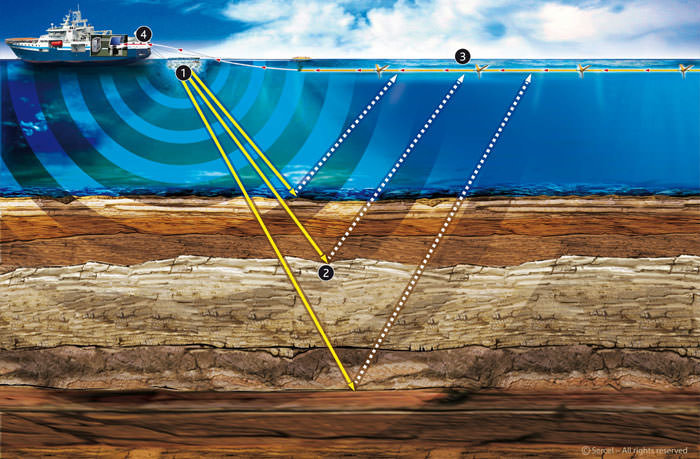

Agora, vamos relembra um pouco de Física ondulatória. Olhando para figura, sabemos que uma determinada frente de onda que saiu da fonte e refletiu na superfície do solo, chegará ao ponto 3 ( Receptor ) com as mesma propriedades de quando saiu de 1 ( Fonte sísmica ). Entretanto, parte dessa onda seguiu sua propagação pelo solo, o que mudou suas propriedades. Consequentimente, parte dessa "nova frente onda" irá interagir com outra superfície, onde ocorrerá o mesmo processo descrito anteriormente. Assim, teremos frentes de onda diferentes chegando nos receptores. E a essa combinação, das diferentes frentes de onda que chegam no receptor, formam o que chamamos de "padrão de amplitude do traço".

Cada receptor terá um padrão de onda específico. E quando distribuimos esses receptores em uma malha, geralmente, igualmente espaçada, teremos o que chamamos de sismogramas. Daí, a ideia de "traço".

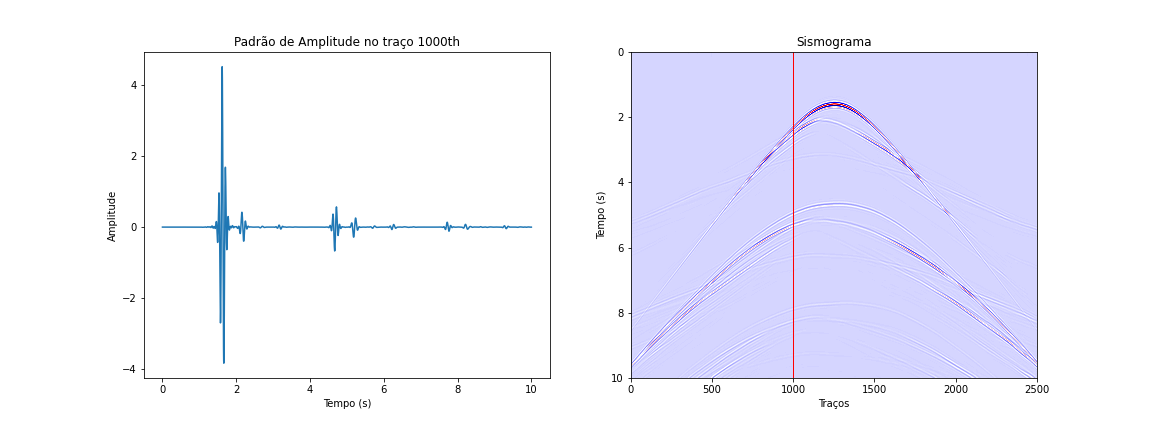

## 2 - A importância da interpolação

****

Assim como nas mais diversas áreas de tratamento de sinais, na sísmica o sinal não é continuo, nem no tempo e muito menos no espaço. A discretização no sinal no espaço depende do número de receptores e o espaçamento entre eles. Sabemos que quando um dado sinal é discretizado, ele está sujeito as condições descritas pelo "Teorema da amostragem" e podemos ter problemas relacionados ao espectro de *Fourier*. Um desses problemas é o chamado *Aliasing*, o qual consiste em uma sobreposição dos espectros causado por uma baixa frequência amostral.

#### Teorema da amostragem :

    "Para que um sinal seja completamente reconstruido é necessário que a frequência amostral seja maior igual a duas vezes frequência máxima desse sinal."

$$w_s \geq 2w_{max}$$

A visualização do *Aliasing* ocorre no que chamamos de domínio $f-k$, o qual é definido fazendo a transformada de *Fourier* no tempo e no espaço do nosso dado. Se o nosso sismograma tiver uma baixa frequência amostral, ou seja, se o espaçamento entre os receptores for muito alto comparado ao comprimento de onda do sinal, então vamos visualizar reflexões na borda do grid, como mostra a figura abaixo.

Felizmente, a maioria das aquisições tem geometria irregular, o que é bom, pois não temos problema de *Aliasing* periódicos. Todovia, como discutido no `Notebook` [Algoritmo de reconstrução esparsa - MPFI](https://github.com/MathPhelip/PET.py/blob/main/Algoritmo%20de%20reconstru%C3%A7%C3%A3o%20esparsa%20-%20MPFI.ipynb) **[3]**, a irregularidade torna o espectro de *Fourier* ruidoso e isso também é um problema.

### 2.1 - FWI (*Full wave inversion*)

Na sísmica, um sismograma não passa muita informação sobre a configuração geológica do espaço que está sendo estudado. Mas, sabemos que o padrão de amplitude presente no sismograma, vem através da propagação de uma onda de pressão em meio acústico. E também sabemos que toda onda é regida pela equação da onda (eq.1), que por sua vez é uma equação diferencial. Uma característica interessante das equações diferencias é que se eu souber o "campo" ( Função derivável ) eu posso determinar os coeficientes, assim como se eu sei os coeficientes, eu possso determinar o "campo". No nosso caso, o campo é a pressão gerada e o coeficiente é a velocidade da onda.

$$\tag{1} \nabla^2p + \frac{1}{c}\frac{\partial^2p}{\partial t^2} = 0,$$

onde $c = \frac{\rho}{B}$, sendo $\rho$ a densidade e $B$ uma constante característica no meio.

Saber o projeção da velocidade para cada ponto do grid espacial, nós dá uma noção melhor da geologia da área estudada. Tal condição, ajuda as empresas de petróleo a otimizar o processo de extração, pois diminui a chance de perfurarem em um local não proprício. O processo de obtenção do campo de velocidade é chamado de FWI (*Full wave inversion*), o qual é sensível, númericamente, ao espectro de *Fourier*

## 3 - Configurando o dado

****

### 3.1 - Importando o dado

Uma vez dada a introdução teórica, vamos importar o dado sísmico que iremos trabalhar.

In [2]:
def importando_dado(amostras, endereço):
    
    dado = np.fromfile(endereço, dtype='float32')
    nrecs = dado.size // amostras
    sismograma = dado.reshape(nrecs, amostras).T
    
    return sismograma

O dado que iremos trabalhar é um dado sintético, com pico de frequência de 17Hz, o espaçamento entre receptores de é 12.5m, com um total de 2501 receptores (traços) e o tempo de amostagem é de 10s. É um dado que não possui *aliasing*.

In [3]:
end = r'C:\Users\Matheus\PET - Física\GdM2D_dataP_bas30km_filterednew.bin'
sismograma = importando_dado(2501, end)

Variáveis importantes.

In [4]:
Nt = sismograma.shape[0]
Nx = sismograma.shape[1]

Tempo = 10 #Tempo em segundos
T = Tempo/Nt #Período de amostragem temporal

dist_entre_recep = 12.5 #Distância entre receptores em metros
extencao = dist_entre_recep*(Nx-1)

tracos = np.arange(Nx)
freq_ite = np.linspace(0, 1/T, Nt)
amostras_temporais = np.linspace(0,Tempo,Nt)
num_onda = np.linspace(-(np.pi)/extencao, (np.pi)/extencao, Nx)*1000
amostragem_espacial_normalizada = np.linspace(0, extencao, Nx)/extencao

Como essa dado é muito grande, vamos recorta-lo para ficar melhor a visualização.

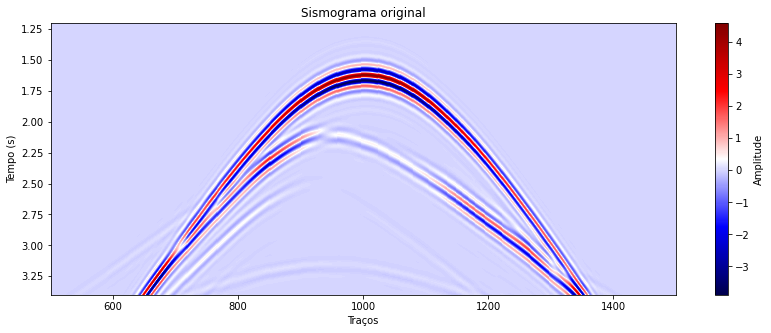

In [5]:
plt.figure(figsize=(14,5))
plt.imshow(sismograma[300:850,500:1500], extent=[500,1500,amostras_temporais[850],amostras_temporais[300]],
           aspect='auto', origin='upper', cmap='seismic')
plt.title('Sismograma original')
plt.ylabel('Tempo (s)')
plt.xlabel('Traços')
plt.colorbar(label='Amplitude')
plt.show()

Podemos observar o pico de frequência para desse dado fazendo a *fft* de qualquer traço.

In [6]:
freq_sample = fft(sismograma[:,400], norm='forward') #Transformada de Fourier

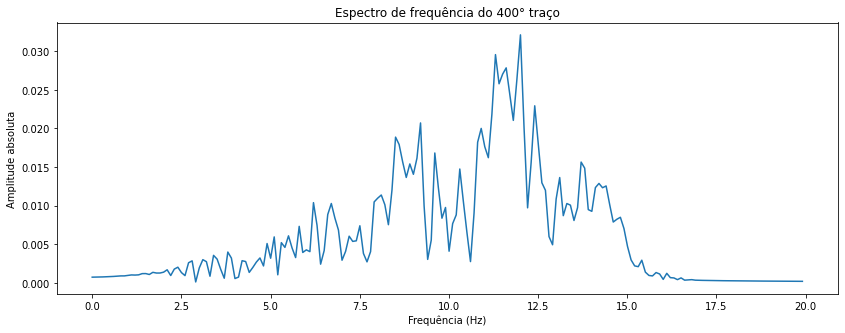

In [7]:
plt.figure(figsize=(14,5))
plt.plot(freq_ite[0:200], abs(freq_sample[0:200]))
plt.title('Espectro de frequência do 400° traço')
plt.ylabel('Amplitude absoluta')
plt.xlabel('Frequência (Hz)')
plt.show()

Como podemos observar o pico de frequência (Frequência para a qual a amplitude vai a zero) dessa dado está na faixa de 17(Hz) como dito anteriormente.

Indo para o espaço $f-k$

In [8]:
fk_domain = fftshift(fft2(sismograma, norm='ortho'), axes=-1)

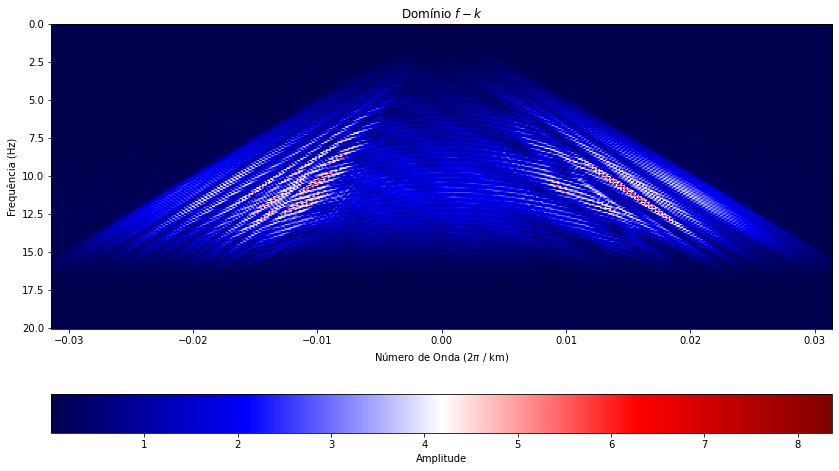

In [9]:
plt.figure(figsize=(14,8))
plt.imshow(abs(fk_domain[0:200,750:1250]), extent=[num_onda[750],num_onda[1250],freq_ite[200],freq_ite[0]], aspect='auto',
                origin='upper', cmap='seismic')
plt.title('Domínio $f-k$')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Número de Onda ($2\pi$ / km)')
plt.colorbar(location='bottom',label='Amplitude')
plt.show()

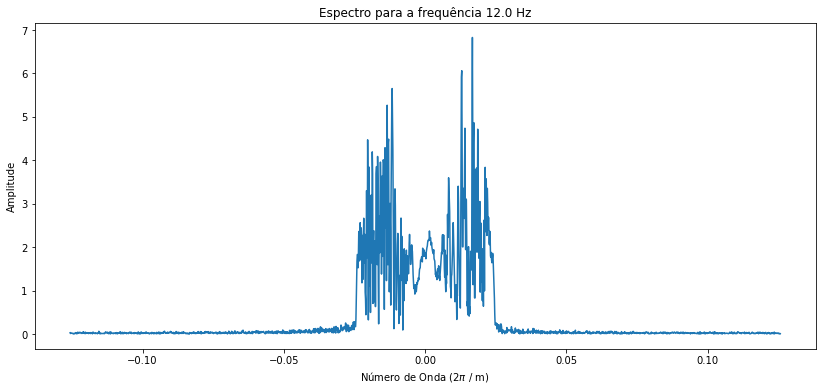

In [10]:
plt.figure(figsize=(14,6))
plt.plot(num_onda, abs(fk_domain[120,:]))
plt.title(f'Espectro para a frequência {round(freq_ite[120],2)} Hz')
plt.ylabel('Amplitude')
plt.xlabel('Número de Onda ($2\pi$ / m)')
plt.show()

### 3.2  - Retirando traços

Agora, vamos imaginar que na hora na aquisição alguns receptores falharam, de modo que nosso dado ficou com alguns traços zerados. Consequentimente, nosso dado ganhou uma geometria irregular, ou seja, teremos pontos de descontinuidade no sinal.

*  **Escolhendo quais traços retirar**

In [11]:
def Decimando_aleatoriamente(sismograma_original, amostragem_original, tracos_original, espacamnto_maximo):

    tracos_decimado = []

    n = 0
    tracos_decimado.append(n)
    
    while n < len(tracos_original) - espacamnto_maximo:
        if n < len(tracos_original):
            #Note que o parâmetro p depende do espaçamento máximo...alterá-lo sempre que necessário
            idx = np.random.choice(np.arange(n+1, n+espacamnto_maximo+1),size=1,p=[0.5,0.1,0.2,0.2])
            tracos_decimado.append(idx[0])
        n = idx[0]

    novo_sismograma, sismograma_decimado, amostragem_decimada = retirando_tracos_nulos(sismograma_original, amostragem_original,tracos_decimado)

    porcent = (100*amostragem_decimada.shape[0])/amostragem_original.shape[0]

    return novo_sismograma, sismograma_decimado, amostragem_decimada, porcent

* **Retirando traços escolhidos**

In [12]:
def retirando_tracos_nulos(sismograma_original, amostragem_original, tracos_decimado):

    sismograma_decimado = np.zeros(sismograma_original.shape, float)
    amostragem_decimada = np.zeros(sismograma_original.shape[1], float)

    for i in range(len(tracos_decimado)):
        sismograma_decimado[:,tracos_decimado[i]] = sismograma_original[:,tracos_decimado[i]]

    for i in range(len(tracos_decimado)):
        amostragem_decimada[tracos_decimado[i]] = amostragem_original[tracos_decimado[i]]


    index = []
    for i in range(sismograma_original.shape[1]):
        n = 0
        for t in range(sismograma_original.shape[0]):
            if sismograma_decimado[t,i] == 0:
                n+=1
        if n == sismograma_original.shape[0]:
              index.append(i)

    novo_sismograma = np.delete(sismograma_decimado, index, axis=1)

    index = []
    if tracos_decimado[0] != 0:
        for i in range(sismograma_original.shape[1]):
            if amostragem_decimada[i] == 0:
                index.append(i)
    else:
        for i in range(1,sismograma_original.shape[1]):
            if amostragem_decimada[i] == 0:
                index.append(i)

    amostragem_decimada = np.delete(amostragem_decimada, index)

    return novo_sismograma, sismograma_decimado, amostragem_decimada

Note que precisamos definir o espaçamento máxima, pois se tirarmos muitos traços, podemos poluir demais o espaço da transformada e assim prejudicando a escolha dos coeficientes.

In [13]:
espacamento_maximo = 4
novo_sismograma, sismograma_decimado, amostragem_decimada, porcent = Decimando_aleatoriamente(sismograma, amostragem_espacial_normalizada, tracos, espacamento_maximo)

Plotando os resultados.

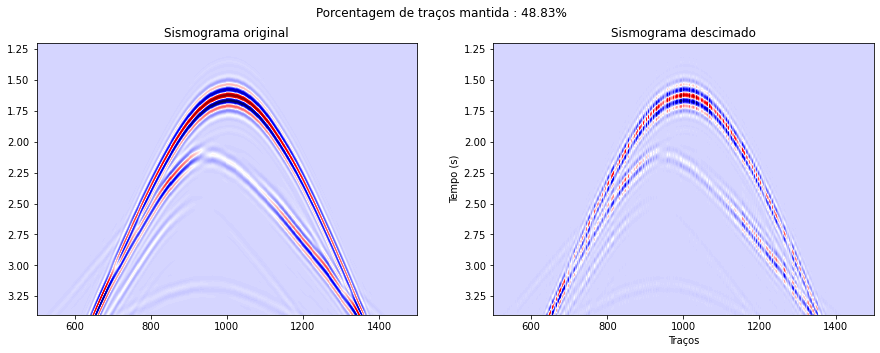

In [14]:
dados = np.array([[sismograma], [sismograma_decimado]])

plt.figure(figsize=(15,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.imshow(dados[i,0][300:850,500:1500], extent=[500,1500,amostras_temporais[850],amostras_temporais[300]],
           aspect='auto', origin='upper', cmap='seismic')
    if i == 0:
        plt.title('Sismograma original')
    elif i == 1:
        plt.title('Sismograma descimado')
plt.suptitle(f'Porcentagem de traços mantida : {round(porcent,2)}%')
plt.ylabel('Tempo (s)')
plt.xlabel('Traços')
plt.show()

Vamos visualizar o espectro de frequência do dado decimado.

In [15]:
espc_dado_decimado = fftshift(fft2(sismograma_decimado, norm='forward'), axes=-1)

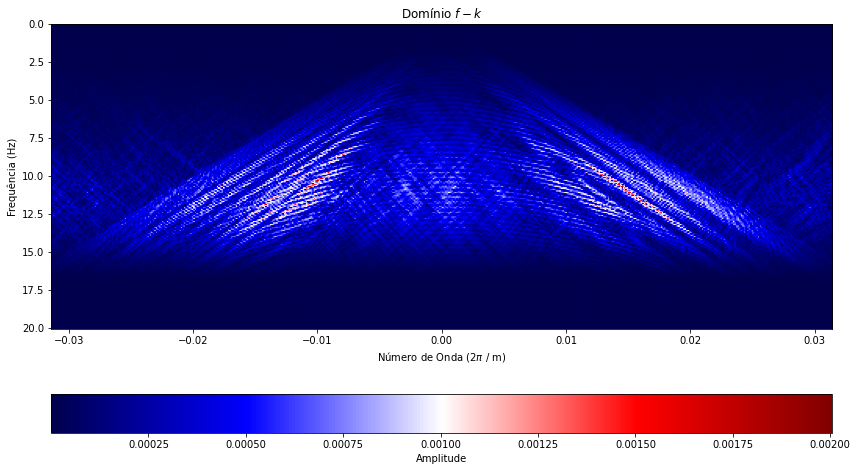

In [16]:
plt.figure(figsize=(14,8))
plt.imshow(abs(espc_dado_decimado[0:200,750:1250]), extent=[num_onda[750],num_onda[1250],freq_ite[200],freq_ite[0]], aspect='auto',
                origin='upper', cmap='seismic')
plt.title('Domínio $f-k$')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Número de Onda ($2\pi$ / m)')
plt.colorbar(location='bottom',label='Amplitude')
plt.show()

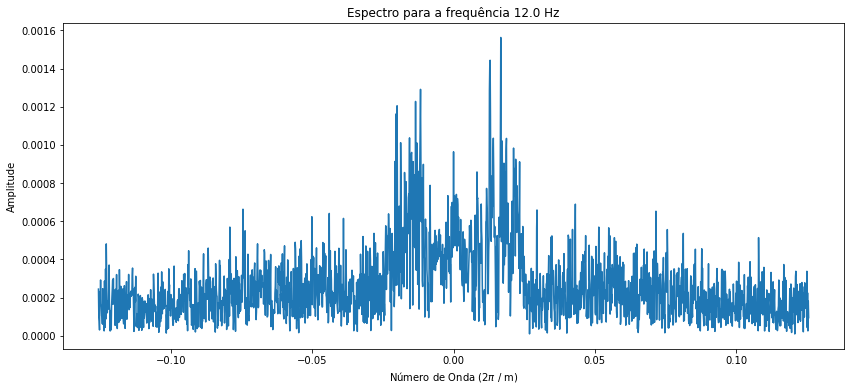

In [17]:
plt.figure(figsize=(14,6))
plt.plot(num_onda, abs(espc_dado_decimado[120,:]))
plt.title(f'Espectro para a frequência {round(freq_ite[120],2)} Hz')
plt.ylabel('Amplitude')
plt.xlabel('Número de Onda ($2\pi$ / m)')
plt.show()

Como já era esperado note que nosso espectro ficou bem ruidoso.

## 4 - Interpolando

****

### 4.1 - Qual espaço usar ?

Diferentimente do notebook anterior, estamos trantando de um array 2D, onde temos a informação temporal e espacial do nosso dado. Note que, a interpolação tem como objetivo criar informação ao longo dos traços, então a função `MPFI` , definida no material anterior, pode ser usada aqui sem alterações importantes, pois continuamos fazendo uma interpolação 1D.

In [18]:
def MPFI(dictionary, y , epsilon):

    r = y
    num_ite = 0
    size_col_dictionary = dictionary.shape[1]
    indices = np.array([])
    x = np.zeros(( size_col_dictionary ,), complex)

    while ( np.linalg.norm(r , ord=2) >= epsilon ) or ( num_ite <= 13 ):
        
        absolute_fourier_domain = abs(np.dot(dictionary.T, r)) # Indo para o espaço da transformada

        max_freq_fourier_domain = max(absolute_fourier_domain) # Pegando a frequência com maior valor absoluto

        indices = np.where( absolute_fourier_domain == max_freq_fourier_domain )[0]

        atoms_selected = dictionary[:, indices ]

        coef_max_value = np.dot(atoms_selected.T, r) 

        x[ indices ] = x[ indices ] + coef_max_value # Guardando as frequências
        r = r - np.dot(coef_max_value, (len(y)*np.conjugate(atoms_selected.T))) # Atualizando o sinal
        num_ite+=1
    
    return x

A questão com a qual temos que nos preocupar é : qual espaço vamos reconstruir ? Ou seja, se vamos interpolar por amostra temporal ou por amostra de frequência.

Note que se usarmos a informação temporal, nosso código levará mais tempo para rodar, pois teremos muita informação para compilar. Agora, se usarmos o espaço das frequências existirá uma região de valores praticamente nulos, a qual permite nosso código passar rapidamente por ela. Como a transformada de *Fourier* guarda toda a informação temporal em uma única amostra de frequência, não precisamos nos preocupar em perde informação do nosso dado.

In [19]:
def Matriz_Transformada(Nk, pontos_normalizados):
    
    Np = len(pontos_normalizados)
    F = np.zeros((Nk,Np), complex)
    
    for k in range(Nk):
        for n in range(Np):
            F[k, n] = (1/Np)*np.exp(-2j*np.pi*k*pontos_normalizados[n])
    
    return F

def Matriz_Transformada_inversa(Nk, pontos_normalizados):
    
    Np = len(pontos_normalizados)
    iF = np.zeros((Np,Nk), complex)
    
    for k in range(Nk):
        for n in range(Np):
            iF[n, k] = np.exp(2j*np.pi*k*pontos_normalizados[n])
    
    return iF

In [20]:
Fx = Matriz_Transformada(Nx, amostragem_decimada)
iFx = Matriz_Transformada_inversa(Nx, amostragem_espacial_normalizada)

Como ao longo do tempo nosso dado continuou uniformimente discretizado, então podemos usar a função `fft2` para ir para o espaço $f-x$. Assim, polpando custo computacional.

In [21]:
tol = 1

novo_espec = np.zeros(fk_domain.shape, complex)
fx_espec = fft2(novo_sismograma, axes=(0,), norm='ortho')

with tqdm(total=fx_espec.shape[0]) as progressing_load:
    for i in range(fx_espec.shape[0]):
        novo_espec[i,:] = MPFI(Fx.T, fx_espec[i,:], tol)
        progressing_load.update(1)

100%|██████████████████████████████████████████████████████████████████████████████| 2501/2501 [06:58<00:00,  5.98it/s]


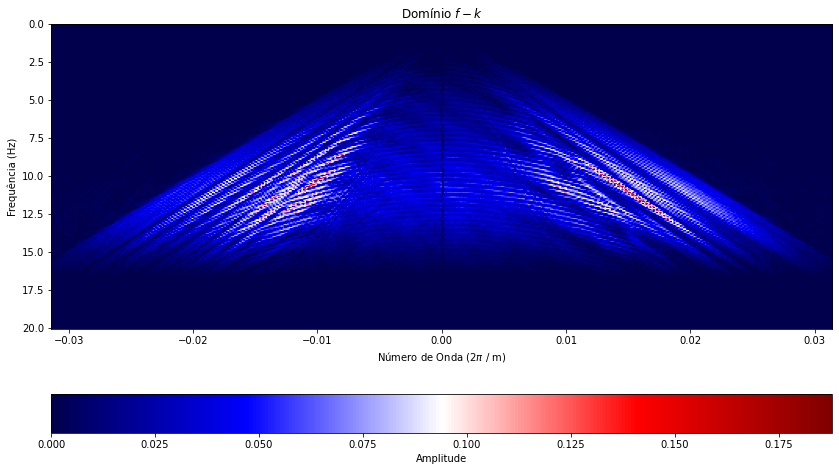

In [22]:
plt.figure(figsize=(14,8))
plt.imshow(abs(fftshift(novo_espec, axes=-1))[0:200,750:1250], extent=[num_onda[750],num_onda[1250],freq_ite[200],freq_ite[0]], aspect='auto',
                origin='upper', cmap='seismic')
plt.title('Domínio $f-k$')
plt.ylabel('Frequência (Hz)')
plt.xlabel('Número de Onda ($2\pi$ / m)')
plt.colorbar(location='bottom',label='Amplitude')
plt.show()

### 4.2 - Construindo um novo dado

Note que o espaço $f-k$ reconstruido é bem semelhante ao do sismograma original. Agora, podemos usá-lo para interpolar, ou seja, criar um sismograma com mais informação.

In [23]:
sismograma_interpolado = ifft2(np.dot(novo_espec, iFx), axes=(0,), norm='ortho').real

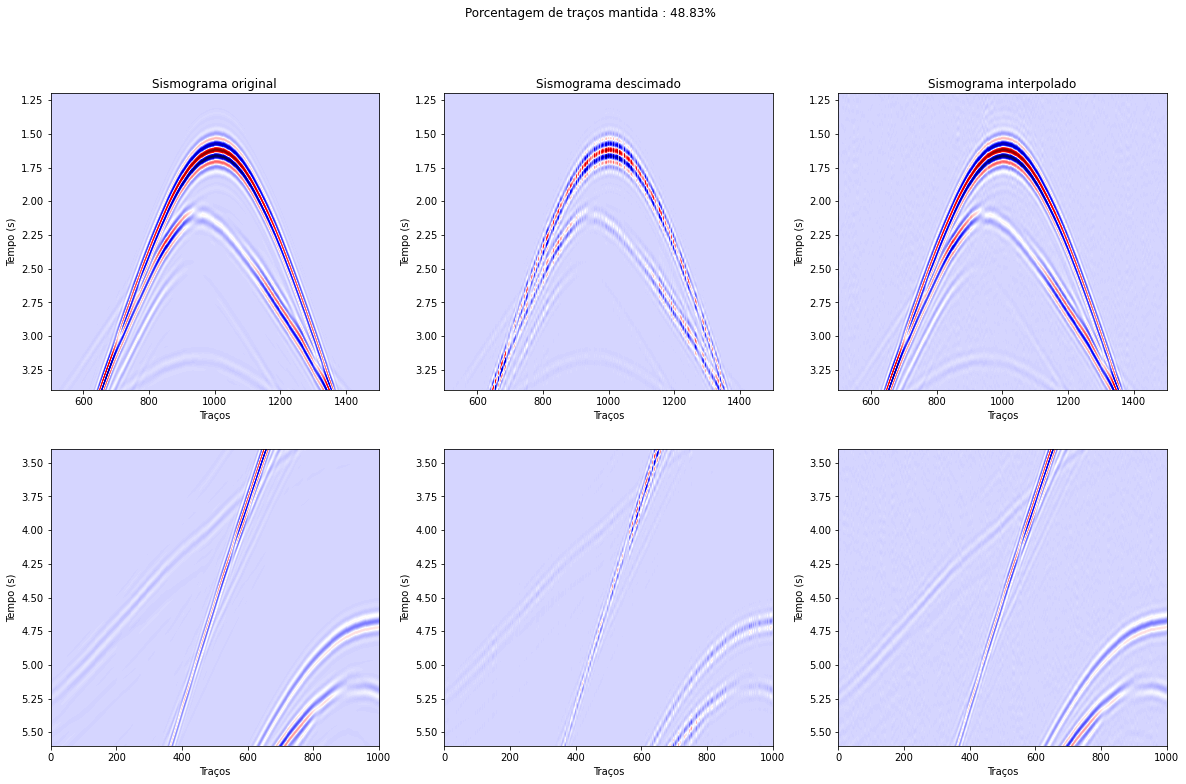

In [24]:
dados = np.array([[sismograma], [sismograma_decimado], [sismograma_interpolado]])

plt.figure(figsize=(20,12))
plt.suptitle(f'Porcentagem de traços mantida : {round(porcent,2)}%')
for i in range(6):
    if i <= 2:
        plt.subplot(2,3,i+1)
        plt.imshow(dados[i,0,300:850,500:1500],vmax=np.max(sismograma), vmin=np.min(sismograma),
                   extent=[500,1500,amostras_temporais[850],amostras_temporais[300]],
                aspect='auto', origin='upper', cmap='seismic')
        if i == 0:
            plt.title('Sismograma original')
        elif i == 1:
            plt.title('Sismograma descimado')
        elif i == 2:
            plt.title('Sismograma interpolado')
    elif i > 2:
        plt.subplot(2,3,i+1)
        plt.imshow(dados[i-3,0,850:1400,0:1000], vmax=np.max(sismograma), vmin=np.min(sismograma),
                   extent=[0,1000,amostras_temporais[1400],amostras_temporais[850]],
                   aspect='auto', origin='upper', cmap='seismic')
    plt.ylabel('Tempo (s)')
    plt.xlabel('Traços')
plt.show()

Podemos ainda, para fins avaliar nossa interpolação, visualizar alguns traços.

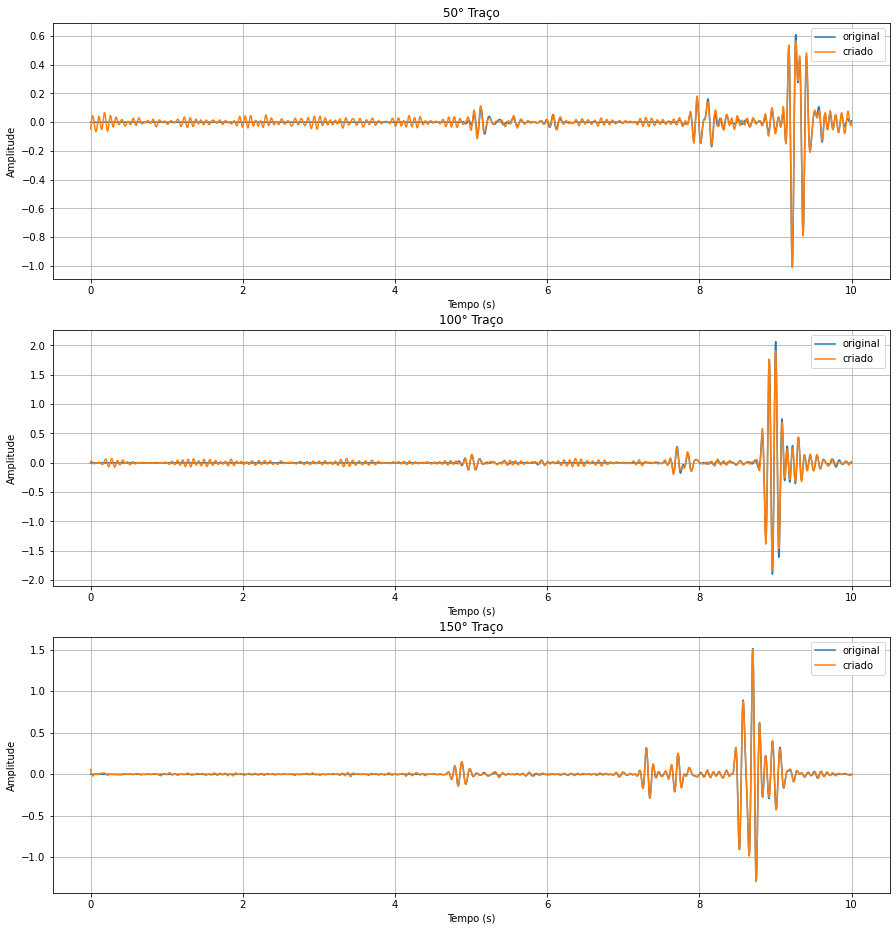

In [25]:
plt.figure(figsize=(15,16))
tr = np.array([50,100,150])

for j in range(3):
    plt.subplot(3,1,j+1)
    plt.title(f'{tr[j]}° Traço')
    plt.plot(amostras_temporais, dados[0,0][:,tr[j]], label='original')
    plt.plot(amostras_temporais, dados[2,0][:,tr[j]], label='criado')
    plt.ylabel('Amplitude')
    plt.xlabel('Tempo (s)')
    plt.legend()
    plt.grid()
plt.show()

### 4.3 - Uma avaliação quantitativa

É muito comum, quando estamos lidando com tratamento de dados, a utilização de métricas que nos passe um informação mais fundamentada sobre a eficácia de determinado modelo. Umas dessas métricas é chamada Coeficiente de determinação ($R^2$), a qual compara dois valores, ou dois conjuntos de valores e retorna um número entre 0 e 1. Essa métrica é regida pela a equação matemática abaixo.

$$\tag{2} R^2 = 1 - \frac{\sum(y - y_{pred})}{\sum(y- \bar{y})},$$

onde $\bar{y}$ é a média $y$.

Essa métrica é bem comum em modelos de regressão usando ML (*Machine Learning*). A ideia é que quanto mais próximo de 1 for $R^2$ melhor foi a aproximação feita pelo modelo.

* **Calculando** $R^2$

In [26]:
r2 = np.zeros(Nx, float)

for trc in range(Nx):
    y_actual = dados[0,0][:,trc]
    y_predicted = dados[2,0][:,trc]
    r2[trc] = r2_score(y_actual,y_predicted)
        
print(f"R2 por traço: {np.mean(r2)}")

R2 por traço: 0.984093570624907


Note que nossa interpolação obteve resultados satisfatórios.

É interessante testar diferentes arrajos alterando o parâmetro `p`, da função `Decimando_aleatoriamente`, e o `espacamento_maximo` para testar a limitações do método para esse dado.

## 5 - Conclusão 

****

O MPFI é amplamente usado no contexto da sismologia pela sua eficácia e baixo custo computacional comparado a outros métodos, como o MWN (*Minimun Weigthed Norm Interpolation*) **[2]** . Contudo, por ser um método simples, ele tem suas limatações. Uma delas é a interpolação de um sinal uniformimente espaçado, que por conta dos *Aliasing* periódicos que custumam aparecer nesse tipo de discretização, os resultados não são satisfatórios. Em virtude nisso, é necessário o auxílio de uma matrix de pesos que amplie a frequências verdadeiras. No geral, esses pesos tem carater empírico, ou seja, é tentativa e erro.

## Referência

* [1] Fourier reconstruction with sparce inversion (2005, Techische Univesiteit Delft), *Paul Maarten ZWARTJES*. Disponível em: https://repository.tudelft.nl/islandora/object/uuid%3A9dfd4050-740f-4728-b1b9-a9364945b435.

* [2] A comparison of 2D Seismic data regularization with MWNI and MP, *Juan de Medeiros Trindade*. Disponível em : https://library.seg.org/doi/10.1190/sbgf2017-272

* [3] *Seismic regularization using Matching Pursuit and ALFT: A comparative study ( 2017 ), Yuri Shalom de Freitas Bezerra*.

* [4] Algoritmo de reconstrução esparsa - MPFI, Matheus Felipe . Disponível em : https://github.com/MathPhelip/PET.py/blob/main/Algoritmo%20de%20reconstru%C3%A7%C3%A3o%20esparsa%20-%20MPFI.ipynb